In [3]:
import os

from IPython.display import set_matplotlib_formats
import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import logsumexp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

plt.style.use('bmh')
if "NUMPYRO_SPHINXBUILD" in os.environ:
    set_matplotlib_formats('svg')

assert numpyro.__version__.startswith('0.6.0')

In [4]:
DATASET_URL = 'https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/WaffleDivorce.csv'
dset = pd.read_csv(DATASET_URL, sep=';')
dset[:5]

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


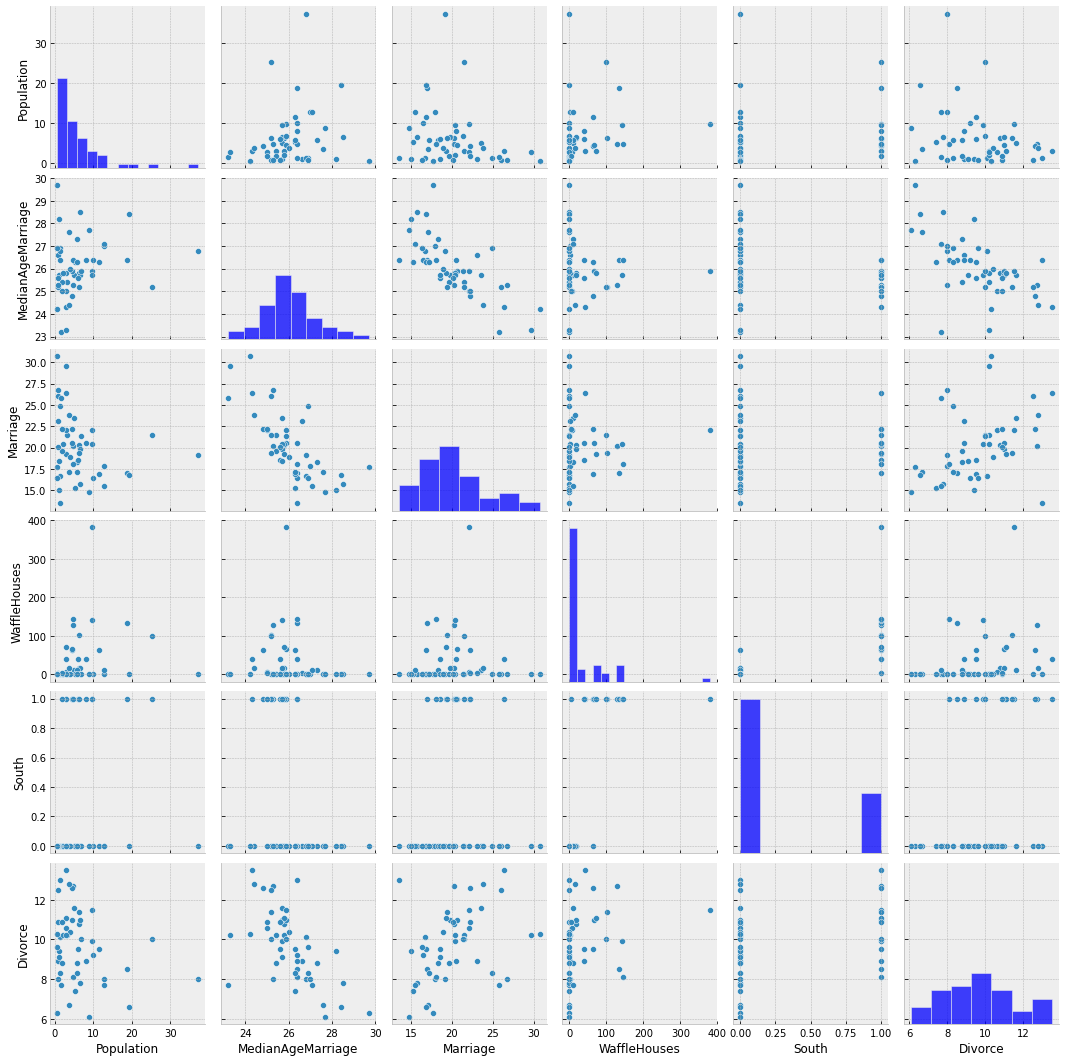

In [5]:
vars = ['Population', 'MedianAgeMarriage', 'Marriage', 'WaffleHouses', 'South', 'Divorce']
sns.pairplot(dset, x_vars=vars, y_vars=vars, palette='husl');

/mnt/disk2/samarth/anaconda3/envs/jax-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='WaffleHouses', ylabel='Divorce'>

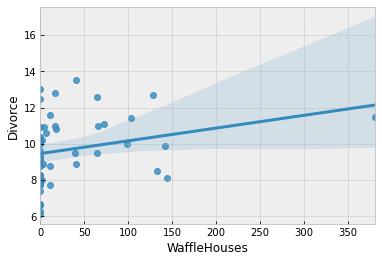

In [6]:
sns.regplot('WaffleHouses', 'Divorce', dset)

In [7]:
standardize = lambda x: (x - x.mean()) / x.std()

dset['AgeScaled'] = dset.MedianAgeMarriage.pipe(standardize)
dset['MarriageScaled'] = dset.Marriage.pipe(standardize)
dset['DivorceScaled'] = dset.Divorce.pipe(standardize)

In [8]:
def model(marriage=None, age=None, divorce=None):
    a = numpyro.sample('a', dist.Normal(0., 0.2))
    M, A = 0., 0.
    if marriage is not None:
        bM = numpyro.sample('bM', dist.Normal(0., 0.5))
        M = bM * marriage
    if age is not None:
        bA = numpyro.sample('bA', dist.Normal(0., 0.5))
        A = bA * age
    sigma = numpyro.sample('sigma', dist.Exponential(1.))
    mu = a + M + A
    numpyro.sample('obs', dist.Normal(mu, sigma), obs=divorce)

In [9]:
# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000)
mcmc.run(rng_key_, marriage=dset.MarriageScaled.values, divorce=dset.DivorceScaled.values)
mcmc.print_summary()
samples_1 = mcmc.get_samples()

sample: 100%|██████████| 3000/3000 [00:06<00:00, 474.26it/s, 3 steps of size 7.77e-01. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.00      0.11     -0.00     -0.17      0.17   1794.52      1.00
        bM      0.35      0.13      0.35      0.14      0.56   1748.73      1.00
     sigma      0.94      0.10      0.94      0.77      1.09   2144.79      1.00

Number of divergences: 0


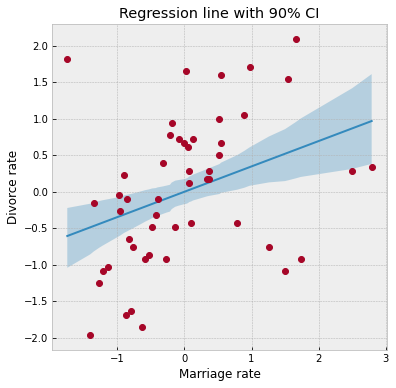

In [10]:
def plot_regression(x, y_mean, y_hpdi):
    # Sort values for plotting by x axis
    idx = jnp.argsort(x)
    marriage = x[idx]
    mean = y_mean[idx]
    hpdi = y_hpdi[:, idx]
    divorce = dset.DivorceScaled.values[idx]

    # Plot
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    ax.plot(marriage, mean)
    ax.plot(marriage, divorce, 'o')
    ax.fill_between(marriage, hpdi[0], hpdi[1], alpha=0.3, interpolate=True)
    return ax

# Compute empirical posterior distribution over mu
posterior_mu = jnp.expand_dims(samples_1['a'], -1) + \
               jnp.expand_dims(samples_1['bM'], -1) * dset.MarriageScaled.values

mean_mu = jnp.mean(posterior_mu, axis=0)
hpdi_mu = hpdi(posterior_mu, 0.9)
ax = plot_regression(dset.MarriageScaled.values, mean_mu, hpdi_mu)
ax.set(xlabel='Marriage rate', ylabel='Divorce rate', title='Regression line with 90% CI');

In [11]:
from numpyro.infer import Predictive

rng_key, rng_key_ = random.split(rng_key)
predictive = Predictive(model, samples_1)
predictions = predictive(rng_key_, marriage=dset.MarriageScaled.values)['obs']
df = dset.filter(['Location'])
df['Mean Predictions'] = jnp.mean(predictions, axis=0)
df.head()

,Location,Mean Predictions
0,Alabama,0.001767
1,Alaska,0.559244
2,Arizona,0.010821
3,Arkansas,0.539718
4,California,-0.074653


In [12]:
def predict(rng_key, post_samples, model, *args, **kwargs):
    model = handlers.seed(handlers.condition(model, post_samples), rng_key)
    model_trace = handlers.trace(model).get_trace(*args, **kwargs)
    return model_trace['obs']['value']

# vectorize predictions via vmap
predict_fn = vmap(lambda rng_key, samples: predict(rng_key, samples, model, marriage=dset.MarriageScaled.values))

In [13]:
# Using the same key as we used for Predictive - note that the results are identical.
predictions_1 = predict_fn(random.split(rng_key_, num_samples), samples_1)

mean_pred = jnp.mean(predictions_1, axis=0)
df = dset.filter(['Location'])
df['Mean Predictions'] = mean_pred
df.head()

NameError: name 'num_samples' is not defined

In [14]:
def log_likelihood(rng_key, params, model, *args, **kwargs):
    model = handlers.condition(model, params)
    model_trace = handlers.trace(model).get_trace(*args, **kwargs)
    obs_node = model_trace['obs']
    return obs_node['fn'].log_prob(obs_node['value'])

def log_pred_density(rng_key, params, model, *args, **kwargs):
    n = list(params.values())[0].shape[0]
    log_lk_fn = vmap(lambda rng_key, params: log_likelihood(rng_key, params, model, *args, **kwargs))
    log_lk_vals = log_lk_fn(random.split(rng_key, n), params)
    return (logsumexp(log_lk_vals, 0) - jnp.log(n)).sum()

In [15]:
rng_key, rng_key_ = random.split(rng_key)
print('Log posterior predictive density: {}'.format(log_pred_density(rng_key_,
                                                                     samples_1,
                                                                     model,
                                                                     marriage=dset.MarriageScaled.values,
                                                                     divorce=dset.DivorceScaled.values)))

Log posterior predictive density: -66.66691589355469


In [16]:
rng_key, rng_key_ = random.split(rng_key)

mcmc.run(rng_key_, age=dset.AgeScaled.values, divorce=dset.DivorceScaled.values)
mcmc.print_summary()
samples_2 = mcmc.get_samples()

sample: 100%|██████████| 3000/3000 [00:06<00:00, 473.84it/s, 7 steps of size 6.99e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.00      0.10      0.00     -0.16      0.17   1856.06      1.00
        bA     -0.57      0.11     -0.57     -0.76     -0.39   1566.43      1.00
     sigma      0.82      0.09      0.82      0.69      0.97   1707.74      1.00

Number of divergences: 0


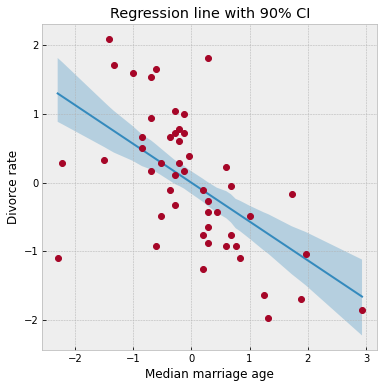

In [17]:
posterior_mu = jnp.expand_dims(samples_2['a'], -1) + \
               jnp.expand_dims(samples_2['bA'], -1) * dset.AgeScaled.values
mean_mu = jnp.mean(posterior_mu, axis=0)
hpdi_mu = hpdi(posterior_mu, 0.9)
ax = plot_regression(dset.AgeScaled.values, mean_mu, hpdi_mu)
ax.set(xlabel='Median marriage age', ylabel='Divorce rate', title='Regression line with 90% CI');

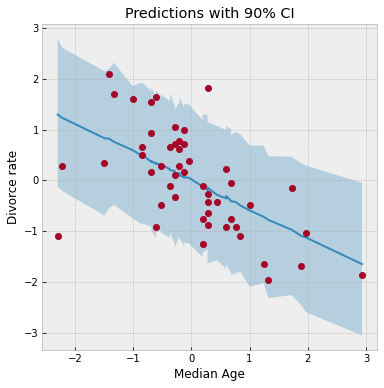

In [18]:
rng_key, rng_key_ = random.split(rng_key)
predictions_2 = Predictive(model, samples_2)(rng_key_,
                                             age=dset.AgeScaled.values)['obs']

mean_pred = jnp.mean(predictions_2, axis=0)
hpdi_pred = hpdi(predictions_2, 0.9)

ax = plot_regression(dset.AgeScaled.values, mean_pred, hpdi_pred)
ax.set(xlabel='Median Age', ylabel='Divorce rate', title='Predictions with 90% CI');